# PlantSpy 2- Classification Type de maladie "Tomato"




## Importer les librairies et connection au Drive

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
import pathlib
from PIL import Image 
from sklearn.model_selection import train_test_split
%matplotlib inline

from matplotlib import cm

from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import VGG16


from sklearn import metrics # Pour évaluer les modèles

import itertools # Pour créer des iterateurs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Recuperation des donnees:


#### Train Dataset

In [ ]:
# folder_path = "/content/drive/MyDrive/Kaggle/new-plant-diseases-dataset/train/"
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/train/"

X_train0=[]
y_train0=[]

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      if ("Tomato" in repertoire) : # On recupere que les Tomates  
      # if ("Tomato" in repertoire) and ("healthy" not in repertoire ) : # On recupere que les Tomates  et sick
        chemin=folder_path+repertoire
        for images in os.listdir(chemin):
          img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
          img_resized = cv2.resize(img, (width,height))
          X_train0.append(np.array(img_resized))
          y_train0.append(repertoire.split('___')[1])   # On recupere le type de maladie seulement 

In [ ]:
X_train0 = np.array(X_train0)
X_train0 = X_train0.astype('float32')


In [ ]:
y_train0= np.array(y_train0)

In [ ]:
X_train0.shape

(18345, 100, 100, 3)

In [ ]:
print(pd.DataFrame(y_train0).value_counts())

Tomato_Yellow_Leaf_Curl_Virus           1961
healthy                                 1926
Early_blight                            1920
Leaf_Mold                               1882
Late_blight                             1851
Target_Spot                             1827
Tomato_mosaic_virus                     1790
Septoria_leaf_spot                      1745
Spider_mites Two-spotted_spider_mite    1741
Bacterial_spot                          1702
dtype: int64


#### Valid Dataset

In [ ]:
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/valid/"

X_valid0=[]
y_valid0=[]

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      # if ("Tomato" in repertoire) and ("healthy" not in repertoire): # On recupere que les Tomates et que les malades
      if ("Tomato" in repertoire) : # On recupere que les Tomates  
        chemin=folder_path+repertoire
        for images in os.listdir(chemin):
          img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
          img_resized = cv2.resize(img, (width,height))
          X_valid0.append(np.array(img_resized))
          y_valid0.append(repertoire.split('___')[1])   # On recupere le type de maladie seulement 


In [ ]:
X_valid0= np.array(X_valid0)
X_valid0 = X_valid0.astype('float32')

y_valid0= np.array(y_valid0)

In [ ]:
X_valid0.shape

(4585, 100, 100, 3)

In [ ]:
pd.DataFrame(y_valid0).value_counts()

Tomato_Yellow_Leaf_Curl_Virus           490
healthy                                 481
Early_blight                            480
Leaf_Mold                               470
Late_blight                             463
Target_Spot                             457
Tomato_mosaic_virus                     448
Septoria_leaf_spot                      436
Spider_mites Two-spotted_spider_mite    435
Bacterial_spot                          425
dtype: int64

## DataViz

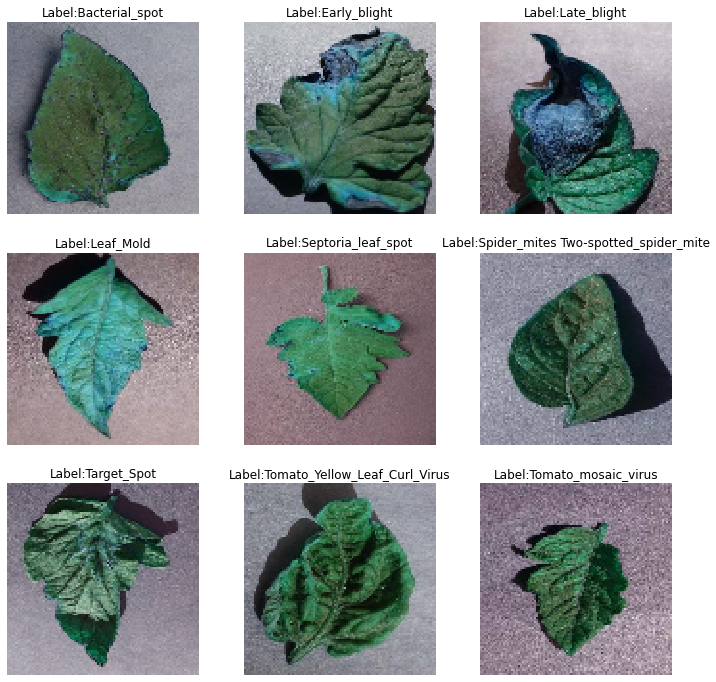

In [ ]:
list_maladie = [ 'Bacterial_spot' ,'Early_blight' ,'Late_blight' ,'Leaf_Mold','Septoria_leaf_spot' , 'Spider_mites Two-spotted_spider_mite' ,
                'Target_Spot' , 'Tomato_Yellow_Leaf_Curl_Virus' , 'Tomato_mosaic_virus' ]

plt.subplots(3, 3, figsize=(12, 12))


k=np.random.choice(np.arange(0, 400), size=9)

for i in range(0,9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  img=X_valid0[y_valid0==list_maladie[i]][k[i]]/255
  plt.imshow(img, interpolation='None')
  plt.title('Label:'+str(list_maladie[i]))




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


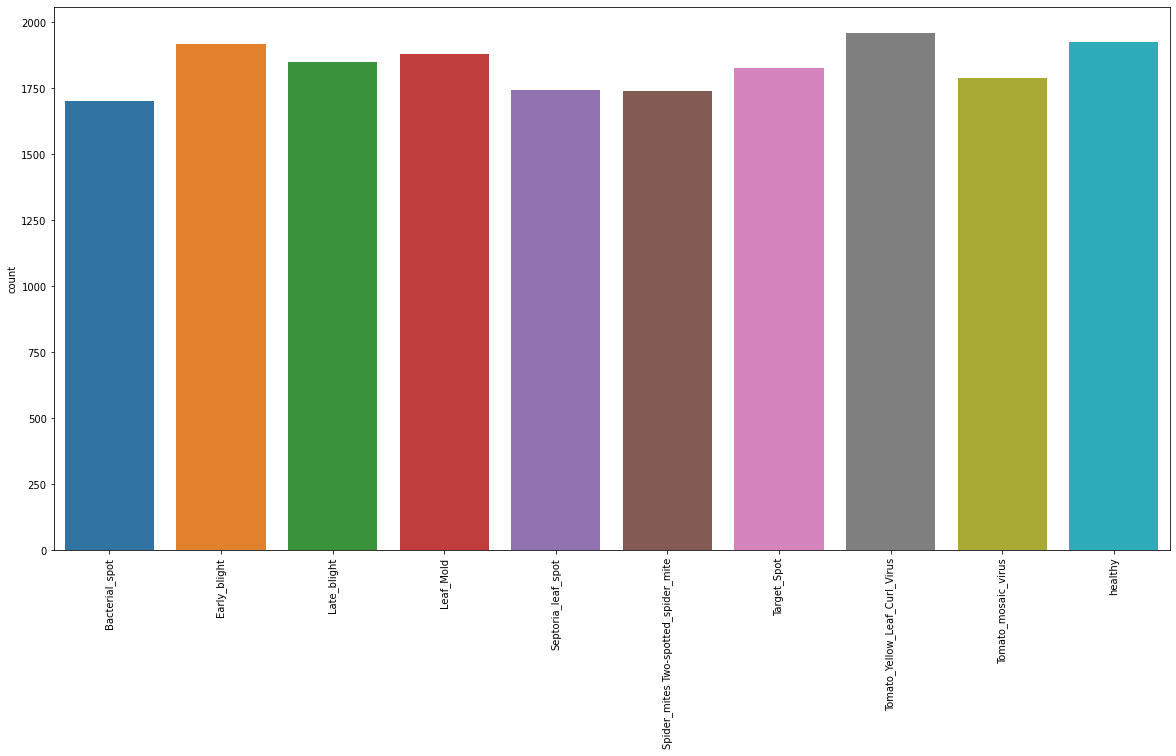

In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 10))

sns.countplot(y_train0)
plt.xticks(rotation=90);

In [ ]:
pd.DataFrame(y_train0).value_counts()

Tomato_Yellow_Leaf_Curl_Virus           1961
healthy                                 1926
Early_blight                            1920
Leaf_Mold                               1882
Late_blight                             1851
Target_Spot                             1827
Tomato_mosaic_virus                     1790
Septoria_leaf_spot                      1745
Spider_mites Two-spotted_spider_mite    1741
Bacterial_spot                          1702
dtype: int64

## Preprocessing

In [ ]:
#sans healthy:
# X_train=X_train0[y_train0!="healthy"]
# y_train=y_train0[y_train0!="healthy"]

# X_valid=X_valid0[y_valid0!="healthy"]
# y_valid=y_valid0[y_valid0!="healthy"]

# print('Shape of  Train0:', y_train0.shape)
# print('Shape of train:',y_train.shape)

In [ ]:
# Diviser les pixels des données X_train et X_test par 255 afin qu'ils soient compris entre 0 et 1
# X_train = X_train / 255
# X_valid = X_valid / 255

X_train = X_train0 / 255
X_valid = X_valid0 / 255

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y_train = encoder.fit_transform(y_train0)
y_valid = encoder.transform(y_valid0)

In [ ]:
# # Pour retrouver facilement les noms des labels
# # dict_maladie = { 0: 'Bacterial_spot' ,
# #                  1: 'Early_blight' ,
# #                  2 : 'healthy',
# #                  3 : 'Late_blight' ,
# #                  4 : 'Leaf_Mold',
# #                  5: 'Septoria_leaf_spot' ,
# #                  6: 'Spider_mites Two-spotted_spider_mite' ,
# #                  7: 'Target_Spot' ,
# #                  8 : 'Tomato_Yellow_Leaf_Curl_Virus' ,
# #                  9 : 'Tomato_mosaic_virus'}

# # list_maladie = [ 'Bacterial_spot' ,'Early_blight' ,'healthy', 'Late_blight' ,'Leaf_Mold','Septoria_leaf_spot' , 'Spider_mites Two-spotted_spider_mite' ,
# #                 'Target_Spot' , 'Tomato_Yellow_Leaf_Curl_Virus' , 'Tomato_mosaic_virus'  ]

# list_maladie = [ 'Bacterial_spot' ,'Early_blight' ,'Late_blight' ,'Leaf_Mold','Septoria_leaf_spot' , 'Spider_mites Two-spotted_spider_mite' ,
#                 'Target_Spot' , 'Tomato_Yellow_Leaf_Curl_Virus' , 'Tomato_mosaic_virus'  ]


In [ ]:
# Shape of X_train and y_train
print('Shape of X Train:', X_train.shape)
print('Shape of y train:',y_train.shape)

print('Shape of X valid:', X_valid.shape)
print('Shape of y valid:',y_valid.shape)

Shape of X Train: (18345, 100, 100, 3)
Shape of y train: (18345,)
Shape of X valid: (4585, 100, 100, 3)
Shape of y valid: (4585,)


In [ ]:
pd.DataFrame(y_valid).value_counts()

## Callbacks

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 8,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=2,
                            mode='min')

## Generateur de donnees

In [ ]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=1,
        height_shift_range=1,
        zoom_range=[0.7, 1.2],
        horizontal_flip=True)

test_data_generator = ImageDataGenerator()

In [ ]:
batch_size = 100

training_data = train_data_generator.flow(X_train, y_train, batch_size=batch_size)
test_data = test_data_generator.flow(X_valid, y_valid, batch_size=batch_size)

# 1er Modele: Architecture LeNet avec generateur d'images

#### Architecture Lenet

In [ ]:
input_shape = (100,100,3)

In [ ]:
model_Tomate1 = Sequential()
model_Tomate1.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_Tomate1.add(MaxPooling2D(pool_size=(3, 3)))
model_Tomate1.add(Dropout(rate=0.2))
model_Tomate1.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_Tomate1.add(MaxPooling2D(pool_size=(2, 2)))
model_Tomate1.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_Tomate1.add(MaxPooling2D(pool_size=(2, 2)))
model_Tomate1.add(Dropout(rate=0.2))
model_Tomate1.add(Flatten())
model_Tomate1.add(Dense(units=64, activation='relu'))
model_Tomate1.add(Dense(units=10, activation='softmax')) # 10 avec healthy

In [ ]:
model_Tomate1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_Tomate1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 30)        2280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 30)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 30)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        17344     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 32)       

In [ ]:
history_Tomate1 = model_Tomate1.fit_generator(generator = training_data, 
                              epochs = 20,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
183/183 [==============================] - 139s 752ms/step - loss: 1.9433 - accuracy: 0.2853 - val_loss: 1.5156 - val_accuracy: 0.4738 - lr: 0.0010
Epoch 2/20
183/183 [==============================] - 132s 722ms/step - loss: 1.2640 - accuracy: 0.5685 - val_loss: 0.8697 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 3/20
183/183 [==============================] - 135s 735ms/step - loss: 0.9443 - accuracy: 0.6736 - val_loss: 0.7078 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 4/20
183/183 [==============================] - 139s 760ms/step - loss: 0.7582 - accuracy: 0.7381 - val_loss: 0.6460 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 5/20
183/183 [==============================] - 135s 736ms/step - loss: 0.6576 - accuracy: 0.7704 - val_loss: 0.6085 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 6/20
183/183 [==============================] - 134s 731ms/step - loss: 0.5754 - accuracy: 0.7958 - val_loss: 0.5017 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 7/20
183/183 [==========================

In [ ]:
model_Tomate1.save('/content/drive/MyDrive/model_Tomate_avec_Healthy_softmax')

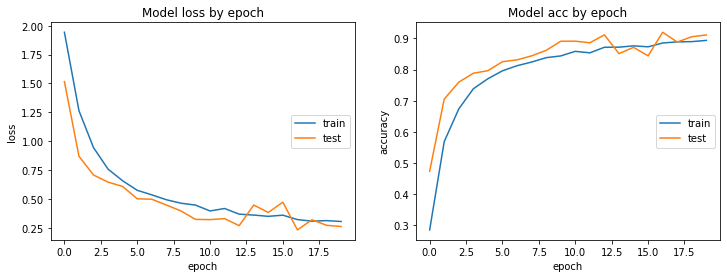

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Tomate1.history['loss'])
plt.plot(history_Tomate1.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_Tomate1.history['accuracy'])
plt.plot(history_Tomate1.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
test_pred_Tomate1 = model_Tomate1.predict(X_valid)

test_pred_Tomate1_class = test_pred_Tomate1.argmax(axis = 1)

In [ ]:
# on met les labels pour que ce soit plus facile a lire
# test_pred_Tomate1_label = (pd.DataFrame(test_pred_Tomate1_class, columns=['maladie'])).replace({"maladie": dict_maladie}).to_numpy()
# y_valid_label = (pd.DataFrame(y_valid, columns=['maladie'])).replace({"maladie": dict_maladie}).to_numpy()

test_pred_Tomate1_label = encoder.inverse_transform(test_pred_Tomate1_class)
y_valid_label =encoder.inverse_transform( y_valid)


In [ ]:
print(y_valid_label)

['Bacterial_spot' 'Bacterial_spot' 'Bacterial_spot' ... 'healthy'
 'healthy' 'healthy']


In [ ]:
print(metrics.classification_report(y_valid_label, test_pred_Tomate1_label))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.96      0.92      0.94       425
                        Early_blight       0.75      0.97      0.85       480
                         Late_blight       0.95      0.82      0.88       463
                           Leaf_Mold       0.94      0.95      0.95       470
                  Septoria_leaf_spot       0.92      0.88      0.90       436
Spider_mites Two-spotted_spider_mite       0.93      0.85      0.89       435
                         Target_Spot       0.92      0.80      0.86       457
       Tomato_Yellow_Leaf_Curl_Virus       0.98      0.93      0.95       490
                 Tomato_mosaic_virus       0.98      0.98      0.98       448
                             healthy       0.87      0.99      0.93       481

                            accuracy                           0.91      4585
                           macro avg       0.92      0.91     

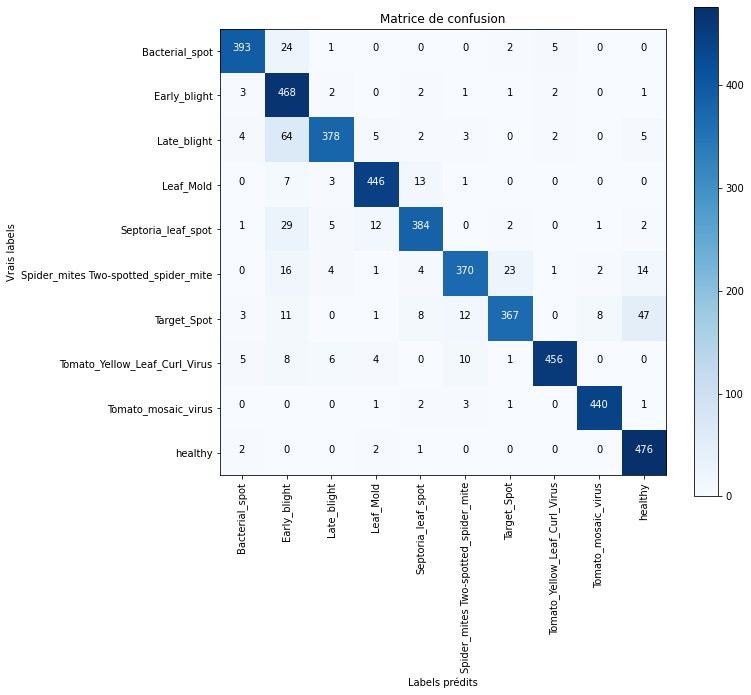

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_Tomate1_label)
list_maladie = [ 'Bacterial_spot' ,'Early_blight' , 'Late_blight' ,'Leaf_Mold','Septoria_leaf_spot' , 'Spider_mites Two-spotted_spider_mite' ,
               'Target_Spot' , 'Tomato_Yellow_Leaf_Curl_Virus' , 'Tomato_mosaic_virus' ,'healthy' ]

classes = range(0,10)
plt.figure(figsize=(10, 9))

# classes = range(0,10)
# plt.figure(figsize=(10, 10))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks([0,1,2,3,4,5,6,7,8,9], list_maladie )
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9],list_maladie,
                  rotation = 90)

# plt.yticks([0,1,2,3,4,5,6,7,8], list_maladie )
# plt.ylabel('Vrais labels')
# plt.xticks([0,1,2,3,4,5,6,7,8],list_maladie,
#                   rotation = 90)

plt.xlabel('Labels prédits')

plt.show()